# Case Study Part 2 : <br>Create Port Profiles and Clustering on Network Data Plane Traffic 

##### This notebook is to be run preferably after running  
Network_Traffic-Data_Analysis-1.ipynb <br> where the first part of this case study is done and that will set a right context to understand the analysis done here.


The packet data analysed here is taken from 
https://www.netresec.com/?page=MACCDC


We follow the below steps
#### 1. Create full port profiles for all the hosts
#### 2. Use PCA to reduce the dimension of the port profiles 
#### 3. K-Means clustering of hosts based on the port profiles
#### 4. Analysis of host Clusters


In [1]:
import datetime
import pandas as pd

In [2]:
import matplotlib as plt
import matplotlib.pyplot as pyplot

import MyTrafficAnalyzer as myan

Read the csv file containing packets data

In [3]:
df_file = "pcaps.csv"

df = pd.read_csv(df_file, parse_dates=["timestamp"], \
                 dtype=object, index_col=["timestamp"])

print(sorted(df.columns))
print(df.shape)

['Unnamed: 0', 'arpdst', 'arpop', 'arppdst', 'arppsrc', 'arpsrc', 'bootpchaddr', 'bootpciaddr', 'bootpgiaddr', 'bootpop', 'bootpsiaddr', 'bootpyiaddr', 'dhcpoptions', 'dnsopcode', 'edst', 'esrc', 'etype', 'icmpcode', 'icmptype', 'id', 'idst', 'iperrordst', 'iperrorproto', 'iperrorsrc', 'iplen', 'iproto', 'ipttl', 'isrc', 'len', 'ntpmode', 'tdport', 'tsport', 'twindow', 'uerrordst', 'uerrorsrc', 'ulen', 'utdport', 'utsport', 'vlan']
(5998837, 39)


### 1. Create full port profiles for all the hosts

Separate and collect data of ports used by each host in the data.
It can be TCP or UDP, and source port or destination port.

In [4]:
h=df[['isrc','tdport']].copy()
h.rename(columns={"isrc": "host", "tdport": "ports"}, inplace=True)

h1 = df[['isrc','tsport']].copy()
h1.rename(columns={"isrc": "host", "tsport": "ports"}, inplace=True)

h2 = df[['isrc','utsport']].copy()
h2.rename(columns={"isrc": "host", "utsport": "ports"}, inplace=True)

h3 = df[['isrc','utdport']].copy()
h3.rename(columns={"isrc": "host", "utdport": "ports"}, inplace=True)

h4 = pd.concat([h, h1, h2, h3])
h4

,host,ports
timestamp,,
2012-03-16 18:00:00.000,192.168.229.254,46117
2012-03-16 18:00:00.000,192.168.202.79,443
2012-03-16 18:00:00.000,192.168.202.79,80
2012-03-16 18:00:00.000,192.168.229.254,46117
2012-03-16 18:00:00.000,192.168.202.79,80
...,...,...
2012-03-16 18:49:57.250,192.168.202.110,NaN
2012-03-16 18:49:57.250,192.168.27.253,NaN
2012-03-16 18:49:57.250,192.168.27.253,NaN


In [5]:
h5 = h4.reset_index()
del h5['timestamp']

h6 = h5.drop_duplicates(['host', 'ports'])
h7 = h6.dropna().copy()

h7.ports = h7.ports.astype(str)
h7.host = h7.host.astype(str)

h7

,host,ports
0,192.168.229.254,46117
1,192.168.202.79,443
2,192.168.202.79,80
5,192.168.202.79,445
6,192.168.229.251,50463
...,...,...
23848338,192.168.207.4,54037
23879334,192.168.207.4,44824
23912636,192.168.207.4,44472
23948549,192.168.207.4,58762


Create a new portprofile field from the dataframe above.
We are simply listing all the ports associated with each host, regardless of protocol (TCP or UDP) and direction (source or destination)

In [6]:
h7['portprofile'] = h7.groupby(['host'])['ports'].transform(lambda x: ' '.join(x))
h7

,host,ports,portprofile
0,192.168.229.254,46117,46117 46119 46121 46123 46125 46127 46129 4613...
1,192.168.202.79,443,443 80 445 135 139 143 1 25 53 88 110 3306 326...
2,192.168.202.79,80,443 80 445 135 139 143 1 25 53 88 110 3306 326...
5,192.168.202.79,445,443 80 445 135 139 143 1 25 53 88 110 3306 326...
6,192.168.229.251,50463,50463 50465 50467 50469 50471 50473 50475 5047...
...,...,...,...
23848338,192.168.207.4,54037,53 56773 1653 57144 58115 60440 56191 52891 42...
23879334,192.168.207.4,44824,53 56773 1653 57144 58115 60440 56191 52891 42...
23912636,192.168.207.4,44472,53 56773 1653 57144 58115 60440 56191 52891 42...
23948549,192.168.207.4,58762,53 56773 1653 57144 58115 60440 56191 52891 42...


In [7]:
h8 = h7.drop_duplicates(['host', 'portprofile']).reset_index().copy()
h8

,index,host,ports,portprofile
0,0,192.168.229.254,46117,46117 46119 46121 46123 46125 46127 46129 4613...
1,1,192.168.202.79,443,443 80 445 135 139 143 1 25 53 88 110 3306 326...
2,6,192.168.229.251,50463,50463 50465 50467 50469 50471 50473 50475 5047...
3,14,192.168.229.153,55173,55173 59930 59931 59934 34494 59936 59962 5996...
4,505,192.168.202.76,40006,40006 40046 80 443 40030 40024 33033 40020 400...
...,...,...,...,...
165,13910211,192.168.202.108,50436,50436 51272 35757 54055 44705 44885 45921 4489...
166,14137103,192.168.202.57,50228,50228 5060
167,15627811,192.168.202.115,137,137 138 50216 53
168,16509486,192.168.202.116,34664,34664 55500 37213 123 68 53 67


In [8]:
del h8['ports']
del h8['index']
h8

,host,portprofile
0,192.168.229.254,46117 46119 46121 46123 46125 46127 46129 4613...
1,192.168.202.79,443 80 445 135 139 143 1 25 53 88 110 3306 326...
2,192.168.229.251,50463 50465 50467 50469 50471 50473 50475 5047...
3,192.168.229.153,55173 59930 59931 59934 34494 59936 59962 5996...
4,192.168.202.76,40006 40046 80 443 40030 40024 33033 40020 400...
...,...,...
165,192.168.202.108,50436 51272 35757 54055 44705 44885 45921 4489...
166,192.168.202.57,50228 5060
167,192.168.202.115,137 138 50216 53
168,192.168.202.116,34664 55500 37213 123 68 53 67


We have successfully created the Port Profile for each host in the network. We have port profiles for 170 hosts.<br>

We will use sklearn CountVectorizer to encode the portprofiles of each host as counts (Bag of words) of each port.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

word_transform = vectorizer.fit_transform(h8['portprofile'])

print(word_transform)
word_transform.shape

  (0, 40128)	1
  (0, 40130)	1
  (0, 40133)	1
  (0, 40135)	1
  (0, 40137)	1
  (0, 40139)	1
  (0, 40141)	1
  (0, 40144)	1
  (0, 40146)	1
  (0, 40148)	1
  (0, 40150)	1
  (0, 40152)	1
  (0, 40155)	1
  (0, 40157)	1
  (0, 40159)	1
  (0, 40161)	1
  (0, 40163)	1
  (0, 40166)	1
  (0, 40168)	1
  (0, 40170)	1
  (0, 40173)	1
  (0, 40176)	1
  (0, 40178)	1
  (0, 40180)	1
  (0, 40182)	1
  :	:
  (165, 37355)	1
  (165, 35460)	1
  (165, 42251)	1
  (165, 30003)	1
  (165, 32819)	1
  (165, 42658)	1
  (165, 27227)	1
  (165, 35833)	1
  (165, 38728)	1
  (165, 40911)	1
  (165, 25758)	1
  (166, 45108)	1
  (166, 44695)	1
  (167, 47773)	1
  (167, 4222)	1
  (167, 4111)	1
  (167, 44682)	1
  (168, 47773)	1
  (168, 27403)	1
  (168, 30236)	1
  (168, 61863)	1
  (168, 2556)	1
  (168, 50553)	1
  (168, 61974)	1
  (169, 2556)	1


(170, 65526)

In [10]:
X_matrix = word_transform.todense()
print(X_matrix)
print(X_matrix.shape)

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(170, 65526)


We have formed a encoding matrix above. For each host, <br> 
there is an array of length 65526 (entire range of available ports) and each element of the array indicates whether that port is part of the port profile. 

### 2. Use PCA to reduce the dimension of the port profile from 65526.

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(X_matrix)
pca.explained_variance_ratio_

array([0.85682762, 0.0298984 , 0.02593426, 0.01198774, 0.00970201,
       0.00745108, 0.00726868, 0.00580077, 0.00494286, 0.00451533,
       0.00366498, 0.00310417, 0.00268973, 0.00252869, 0.0017856 ,
       0.00174349, 0.00116714, 0.00114043, 0.00102734, 0.00095487])

We see most of the variance is explained by just one variable. Let's take two as pca1 and pca2 for further analysis.

In [12]:
pca_data = PCA(n_components=2).fit_transform(X_matrix)

pca1=[]
pca2=[]

#print(pca_data)
#print(pca_data.shape)

for i in pca_data:
    pca1.append(i[0])
    pca2.append(i[1])
    
print(len(pca1))
print(len(pca2))

170
170


In [13]:
h8['pca1'] = pca1
h8['pca2'] = pca2

h8[:2]

,host,portprofile,pca1,pca2
0,192.168.229.254,46117 46119 46121 46123 46125 46127 46129 4613...,-28.658177,-9.093016
1,192.168.202.79,443 80 445 135 139 143 1 25 53 88 110 3306 326...,219.954846,-4.411324


In [14]:
h8.describe()

,pca1,pca2
count,1.700000e+02,1.700000e+02
mean,-2.653835e-12,-5.704822e-13
std,8.186048e+01,1.529155e+01
min,-3.549001e+01,-1.534886e+01
25%,-3.535740e+01,-1.270867e+01
50%,-3.299875e+01,-4.411324e+00
75%,-2.964123e+01,1.155242e+01
max,2.199548e+02,8.409725e+01


##### Plot the hosts across the new "Port Profile" dimensions pca1 and pca2 

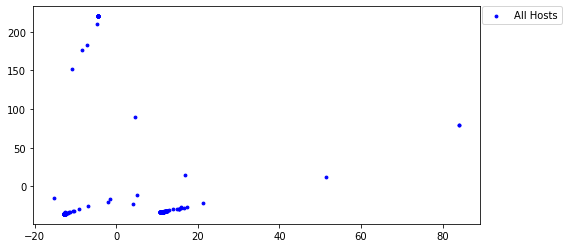

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,4)
plt.scatter(h8['pca2'], h8['pca1'], s=8, color='blue',label="All Hosts")
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.show()

We can see some clusters formed above with few outliers.

### 3. K-Means clustering of hosts based on the port profile

Let us evaluate the optimum number of clusters by elbow method.

In [16]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
tightness = []
possibleKs = range(1,10)
pca_matrix=np.array(h8[['pca2','pca1']])

for k in possibleKs:
    km = KMeans(n_clusters=k).fit(pca_matrix)
    tightness.append(sum(np.min(cdist(pca_matrix, \
      km.cluster_centers_, 'euclidean'), axis=1)) / pca_matrix.shape[0])

C:\Users\rajar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


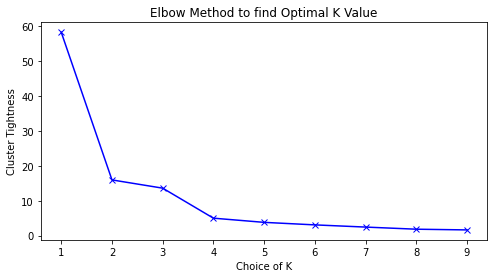

In [17]:
pyplot.plot(possibleKs, tightness, 'bx-')
pyplot.xlabel('Choice of K')
pyplot.ylabel('Cluster Tightness')
pyplot.title('Elbow Method to find Optimal K Value')
pyplot.show()

K=4 seems to be the right choice for clustering. Let us go ahead with clustering with four clusters

In [18]:
kclusters=4
km = KMeans(n_clusters=kclusters,n_init=200,random_state=0)
km.fit_predict(pca_matrix)
h8['kcluster']=km.labels_.tolist()

In [19]:
C_matrix=km.cluster_centers_
print(C_matrix)

[[ 57.63539166  82.77903221]
 [ 12.2601372  -29.73362557]
 [ -5.0588896  212.31761841]
 [-12.49518979 -34.61226224]]


Let us identify the outliers in the clusters, based on the distance from the nearest cluster center.

We will take 2% cutoff to identify hosts considering maximum distance from the nearest cluster center

In [20]:
import scipy
cluster_distance=scipy.spatial.distance.cdist(pca_matrix, C_matrix)
distancecheck=pd.DataFrame(cluster_distance,index=h8.host, \
                           columns=['c0','c1','c2','c3'])
d2=distancecheck.reset_index()
d2[:2]
#cluster_distance

,host,c0,c1,c2,c3
0,192.168.229.254,129.888152,21.380219,241.009560,6.857545
1,192.168.202.79,150.555634,250.244422,7.664633,254.695429


In [21]:
outlier_cutoff=0.02  # Two percent
d2['min_dist'] = d2[['c0','c1','c2','c3']].min(axis=1)
d3=d2.drop(['c0','c1','c2','c3'],axis=1)
d4=d3.sort_values(by='min_dist', ascending=False)
topoutliers=int(len(h8)*outlier_cutoff)
d5=d4[:topoutliers] 
outliers=list(d5.host)
d5

,host,min_dist
15,192.168.27.101,61.403170
130,192.168.203.45,57.806756
74,192.168.27.100,53.451434


In [22]:
print(outliers)
print(topoutliers)

['192.168.27.101', '192.168.203.45', '192.168.27.100']
3


We have identified 3 outliers among the hosts

Let us go ahead to plot the clusters identified via K-Means

In [24]:
h8.head(5)

,host,portprofile,pca1,pca2,kcluster
0,192.168.229.254,46117 46119 46121 46123 46125 46127 46129 4613...,-28.658177,-9.093016,3
1,192.168.202.79,443 80 445 135 139 143 1 25 53 88 110 3306 326...,219.954846,-4.411324,2
2,192.168.229.251,50463 50465 50467 50469 50471 50473 50475 5047...,219.954846,-4.411324,2
3,192.168.229.153,55173 59930 59931 59934 34494 59936 59962 5996...,219.954846,-4.411324,2
4,192.168.202.76,40006 40046 80 443 40030 40024 33033 40020 400...,-25.694812,-6.807290,3


In [25]:

### Create separate data frames for each cluster

df0=h8[h8.kcluster==0]
df1=h8[h8.kcluster==1]
df2=h8[h8.kcluster==2]
df3=h8[h8.kcluster==3]
outlier_df=h8[h8.host.isin(outliers)]
#df4=h8[h8.kcluster==4]
#df5=h8[h8.kcluster==5]

In [26]:
outlier_df

,host,portprofile,pca1,pca2,kcluster
15,192.168.27.101,45691 45692 40244 39843 22281 54127 12345 1234...,151.181532,-10.779756,2
74,192.168.27.100,43767 38828 39977 54004 45162 53897 39463 4226...,90.271440,4.711676,0
130,192.168.203.45,51701 32912 51703 51705 51706 37988 37989 3799...,12.699583,51.516269,1


Plot without specifically marking the outliers.

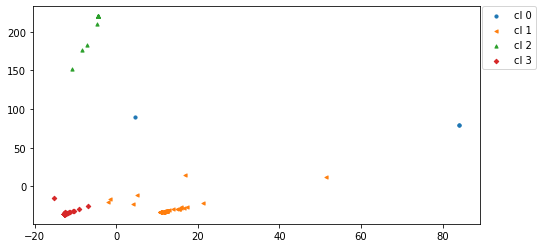

In [27]:
plt.rcParams["figure.figsize"] = (8,4)
pyplot.scatter(df0['pca2'],df0['pca1'],s=10,label="cl 0")
pyplot.scatter(df1['pca2'],df1['pca1'],s=10,marker="<",label="cl 1")
pyplot.scatter(df2['pca2'],df2['pca1'],s=10,marker="^",label="cl 2")
pyplot.scatter(df3['pca2'],df3['pca1'],s=10,marker="D",label="cl 3")

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

Plot clusters specifically identifying outliers

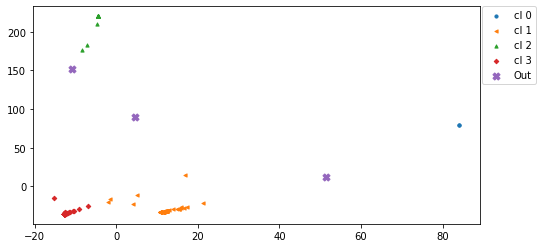

In [28]:
plt.rcParams["figure.figsize"] = (8,4)
pyplot.scatter(df0['pca2'],df0['pca1'],s=10,label="cl 0")
pyplot.scatter(df1['pca2'],df1['pca1'],s=10,marker="<",label="cl 1")
pyplot.scatter(df2['pca2'],df2['pca1'],s=10,marker="^",label="cl 2")
pyplot.scatter(df3['pca2'],df3['pca1'],s=10,marker="D",label="cl 3")
pyplot.scatter(outlier_df['pca2'],outlier_df['pca1'],s=50,marker="X",label="Out")

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

### 4. Analysis Of Host Clusters

Let us check cluster 0 hosts.

In [29]:
df0

,host,portprofile,pca1,pca2,kcluster
47,192.168.202.83,80 443 3389 1723 3306 110 993 256 8888 139 135...,79.032829,84.097249,0
48,192.168.206.44,53839 40497 39173 47342 38162 37552 50492 3495...,79.032829,84.097249,0
74,192.168.27.100,43767 38828 39977 54004 45162 53897 39463 4226...,90.271440,4.711676,0


In [30]:
print(d4[d4.host=='192.168.202.83'].min_dist)
print(d4[d4.host=='192.168.206.44'].min_dist)

print(d4[d4.host=='192.168.27.100'].min_dist)

47    26.725717
Name: min_dist, dtype: float64
48    26.725717
Name: min_dist, dtype: float64
74    53.451434
Name: min_dist, dtype: float64


Cluster 0 is interesting. 
Visually it appears as two entries, but it contains three hosts, 
because 192.168.202.83 and 192.168.206.44 are co-located at same point in the cluster.

We have already noted down these two hosts in part-1 of this case study.

The third host 192.168.27.100 in this cluster is one of the outliers.

In [31]:
# Read the Observations file which contains the observations recorded in part-1 of the case study.

file = open("Observations.txt","r")

notes = file.readlines()
file.close()
for i in notes:
    print(i)

Note-1 : Is the host 192.168.202.83 targeting or scanning 192.168.206.44 ? 

Note-2 : Hosts ending with .254 look like VMware servers using port 22 and 443. 192.168.202.76 appears to be a scanner targeting these hosts 

Potential Scanners List : ['192.168.202.83', '192.168.202.76', '192.168.202.110', '192.168.203.45', '192.168.204.45', '192.168.202.102', '192.168.202.73', '192.168.202.81']

Possible Servers List : ['192.168.201.2', '192.168.202.78', '192.168.205.253', '192.168.206.44', '192.168.207.4', '192.168.21.102', '192.168.21.103', '192.168.21.152', '192.168.21.202', '192.168.21.203', '192.168.21.252', '192.168.21.253', '192.168.21.254', '192.168.22.1', '192.168.22.100', '192.168.22.101', '192.168.22.102', '192.168.22.103', '192.168.22.152', '192.168.22.202', '192.168.22.25', '192.168.22.252', '192.168.22.253', '192.168.22.254', '192.168.229.254', '192.168.23.1', '192.168.23.100', '192.168.23.101', '192.168.23.102', '192.168.23.103', '192.168.23.152', '192.168.23.202', '192.168.2

##### So if you see Note-1 above, the two hosts in cluster 3 are none but the potential scanner and it's target host. <br>


We can recognize that we have built 
###### a clustering method that is showing affinity groups of items that are communicating with each other. 
The unordered source and destination port profiles of these two hosts 192.168.202.83 and 192.168.206.44 are the same and hence the pca1 and pca2 values too. 

##### Let us verify the Note-2 found above and see how the hosts ending with .254 are grouped.

In [32]:
h8[h8.host.str.endswith("254")]

,host,portprofile,pca1,pca2,kcluster
0,192.168.229.254,46117 46119 46121 46123 46125 46127 46129 4613...,-28.658177,-9.093016,3
17,192.168.28.254,53633 51272 51283 51284 51285 46586 46597 4659...,-35.004870,-12.472509,3
23,192.168.23.254,35820 53768 53773 53774 53798 53799 53800 5380...,-35.154597,-12.577218,3
24,192.168.26.254,36254 22113 45992 45997 54061 54065 54066 5407...,-35.161569,-12.590854,3
62,192.168.22.254,52953 52954 52956 52958 52963 52964 52965 5296...,-34.997219,-12.493521,3
65,192.168.21.254,36605 36606 49494 49495 53601 53605 53606 5361...,-34.921522,-12.394248,3
127,192.168.24.254,54754 21623 53893 53898 53899 53908 53909 5391...,-35.165732,-12.585674,3
128,192.168.27.254,22358 41061 41062 41064 54186 54188 54189 5419...,-35.213195,-12.615898,3
141,192.168.25.254,56983 52365 22 443,-35.481671,-12.765354,3
147,192.168.1.254,1900,-35.489940,-12.781709,3


##### Above, we see that all the hosts ending with .254 are grouped together as part of Cluster 3.

From the same Note-2, We saw that 192.168.202.76 is the host which has mostly targeted servers with address ending with .254. <br><br>
##### As expected, we see that this host is also in cluster 3.

In [33]:
h8[h8.host=='192.168.202.76']

,host,portprofile,pca1,pca2,kcluster
4,192.168.202.76,40006 40046 80 443 40030 40024 33033 40020 400...,-25.694812,-6.80729,3


##### Let us plot the clusters identifying the suspected scanners

In [34]:

### Take the "Potential Scanners List" from the Observations.txt that we got earlier.

scanlist = ['192.168.202.83', '192.168.202.76', '192.168.202.110', '192.168.203.45', 
            '192.168.204.45', '192.168.202.102', '192.168.202.73', '192.168.202.81']

sc = h8[h8.host.isin(scanlist)]

sc

,host,portprofile,pca1,pca2,kcluster
4,192.168.202.76,40006 40046 80 443 40030 40024 33033 40020 400...,-25.694812,-6.807290,3
47,192.168.202.83,80 443 3389 1723 3306 110 993 256 8888 139 135...,79.032829,84.097249,0
49,192.168.202.81,55553 17065 445 9200 12110 28024 8154 19885 13...,-11.454007,5.199480,1
77,192.168.202.73,445 443 80 39101 47680 56356 39189 45107 57191...,-19.530366,-2.007686,1
126,192.168.202.102,80 23 443 21 22 25 3389 110 445 139 143 53 912...,-14.977118,-15.348857,3
129,192.168.202.110,1337 31337 5432 443 80 256 111 1720 554 135 10...,219.954846,-4.411324,2
130,192.168.203.45,51701 32912 51703 51705 51706 37988 37989 3799...,12.699583,51.516269,1
135,192.168.204.45,5432 80 443 554 111 587 1720 5900 22 113 21 19...,219.954846,-4.411324,2


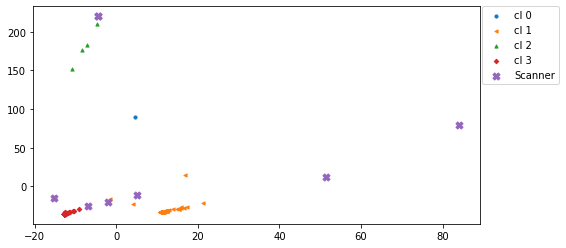

In [35]:
plt.rcParams["figure.figsize"] = (8,4)
pyplot.scatter(df0['pca2'],df0['pca1'], s=10, label="cl 0")
pyplot.scatter(df1['pca2'],df1['pca1'], s=10, marker="<",label="cl 1")
pyplot.scatter(df2['pca2'],df2['pca1'], s=10, marker="^",label="cl 2")
pyplot.scatter(df3['pca2'],df3['pca1'], s=10, marker="D",label="cl 3")
#pyplot.scatter(outlier_df['pca2'],outlier_df['pca1'],s=50,marker="X",label="Out")
pyplot.scatter(sc['pca2'], sc['pca1'], s=50, marker="X", label="Scanner")

#pyplot.scatter(df4['pca2'],df4['pca1'],s=10,marker="<",label="cl 4")
#pyplot.scatter(df5['pca2'],df5['pca1'],s=10,marker=">",label="cl 5")

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

### So, we have identified many different affinity groups and scanners within most of them.

In [36]:
server_lst = ['192.168.201.2', '192.168.202.78', '192.168.205.253', '192.168.206.44', '192.168.207.4', 
                     '192.168.21.102', '192.168.21.103', '192.168.21.152', '192.168.21.202', '192.168.21.203', 
                     '192.168.21.252', '192.168.21.253', '192.168.21.254', '192.168.22.1', '192.168.22.100', 
                     '192.168.22.101', '192.168.22.102', '192.168.22.103', '192.168.22.152', '192.168.22.202', 
                     '192.168.22.25', '192.168.22.252', '192.168.22.253', '192.168.22.254', '192.168.229.254', 
                     '192.168.23.1', '192.168.23.100', '192.168.23.101', '192.168.23.102', '192.168.23.103', 
                     '192.168.23.152', '192.168.23.202', '192.168.23.203', '192.168.23.25', '192.168.23.253', 
                     '192.168.23.254', '192.168.24.1', '192.168.24.101', '192.168.24.102', '192.168.24.103', 
                     '192.168.24.152', '192.168.24.202', '192.168.24.203', '192.168.24.25', '192.168.24.252', 
                     '192.168.24.253', '192.168.24.254', '192.168.25.1', '192.168.25.253', '192.168.26.1', 
                     '192.168.26.101', '192.168.26.102', '192.168.26.103', '192.168.26.152', '192.168.26.202', 
                     '192.168.26.203', '192.168.26.25', '192.168.26.252', '192.168.26.253', '192.168.26.254', 
                     '192.168.27.254', '192.168.28.1', '192.168.28.101', '192.168.28.102', '192.168.28.103', 
                     '192.168.28.152', '192.168.28.202', '192.168.28.203', '192.168.28.25', '192.168.28.252', 
                     '192.168.28.253', '192.168.28.254']

client_lst = ['192.168.202.100', '192.168.202.101', '192.168.202.103', '192.168.202.109', 
              '192.168.202.73', '192.168.202.76', '192.168.202.81', '192.168.202.83', 
              '192.168.202.90', '192.168.202.91', '192.168.202.93', '192.168.202.96', 
              '192.168.203.62']

client_server_lst = server_lst + client_lst

print(len(client_server_lst))

85


In [37]:
#count = 0
#for i in client_server_lst:
#    if i in list(df1.host):
#        count+=1
#print(count)

#count = 0
#for i in list(df1.host):
#    if i in client_server_lst:
 #       count+=1
#print(count)

#print((set(client_server_lst) & set(list(df1.host))))


print(len(set(client_server_lst) & set(list(df0.host))))

print(len(set(client_server_lst) & set(list(df1.host)))) 

print(len(set(client_server_lst) & set(list(df2.host))))

print(len(set(client_server_lst) & set(list(df3.host))))

#print(len(set(client_server_lst)))
#set(list(df0.host)) & set(list(df1.host)) & set(list(df2.host)) & set(list(df3.host))

2
64
0
19


In [38]:
#df2

In [39]:
#myan.host_profile(df, '192.168.202.79')
#myan.port_info(df, '192.168.202.79')

In [40]:
#myan.host_profile(df, '192.168.229.251')
#myan.port_info(df, '192.168.229.251')


In [41]:
#outliers

In [42]:
#for host in outliers:
 #   print("\n\n----------------- " + host + " ------------------\n\n")
  #  myan.host_profile(df, host)
   # myan.port_info(df, host)
    

In [43]:

#print(set(outliers) & set(list(sc.host)))

In [ ]:
#myan.host_profile(df, '192.168.203.45')
#myan.port_info(df, '192.168.203.45')